# Conversion Rate

## Goal

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve it.

## Challenge Description

We have data about all users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:

* Predict conversion rate

* Come up with recommendations for the product team and the marketing team to improve conversion rate

## 1. Import Data

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# read data
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
df = pd.read_csv("conversion_project.csv")

In [3]:
df.shape

(316200, 6)

In [4]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## 2. EDA

1. What's the proportion of users V.S. converted rate in each contry?

<AxesSubplot:xlabel='country'>

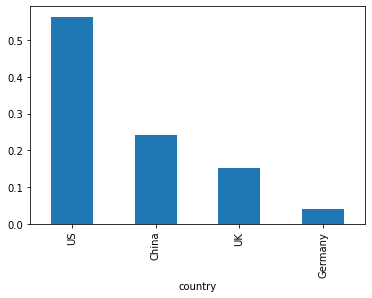

In [5]:
(df.groupby('country')['country'].count()/df.shape[0]).sort_values(ascending = False).plot.bar()

<AxesSubplot:xlabel='country', ylabel='converted'>

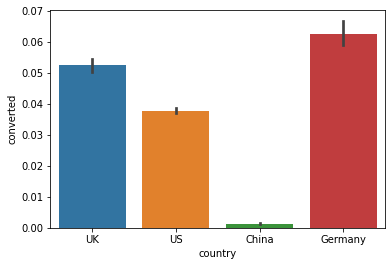

In [6]:
sns.barplot(x = df.country, y = df.converted)

1. More than half of the users are from US, but conversion rate of US users are lower than Germany and UK. 
2. Only 4% of the users are from Germany, however, they have the highest conversion rate. 
3. China has the second most users, but conversion rate of Chinese users are very low.

2. What's the proportion of users V.S. converted rate in each source?

<AxesSubplot:xlabel='source'>

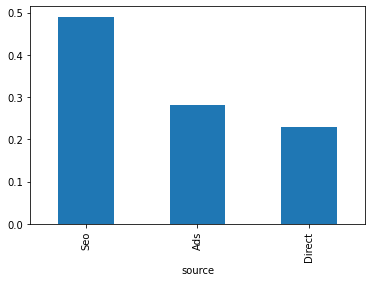

In [7]:
(df.groupby('source')['source'].count()/df.shape[0]).sort_values(ascending = False).plot.bar()

<AxesSubplot:xlabel='source', ylabel='converted'>

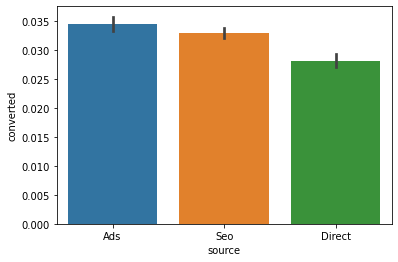

In [8]:
sns.barplot(x = df.source, y = df.converted)

1. About half of the users came to the site by search, but the conversion rate of search users is lower than Ads.
2. Conversion rate of users who directly came to the site is the lowest compared to Ads and Seo.

3. What does the conversion rate look like in both new users and old users?

<AxesSubplot:xlabel='new_user', ylabel='converted'>

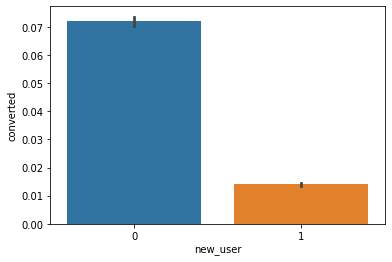

In [9]:
sns.barplot(x = df.new_user, y = df.converted)

5. Let's dive into the "age".

In [10]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


There might be something wrong with the age of users, because the max age is 123, which is not common.

In [11]:
# delete the data of which age is larger than 100.
df = df[df.age < 110]

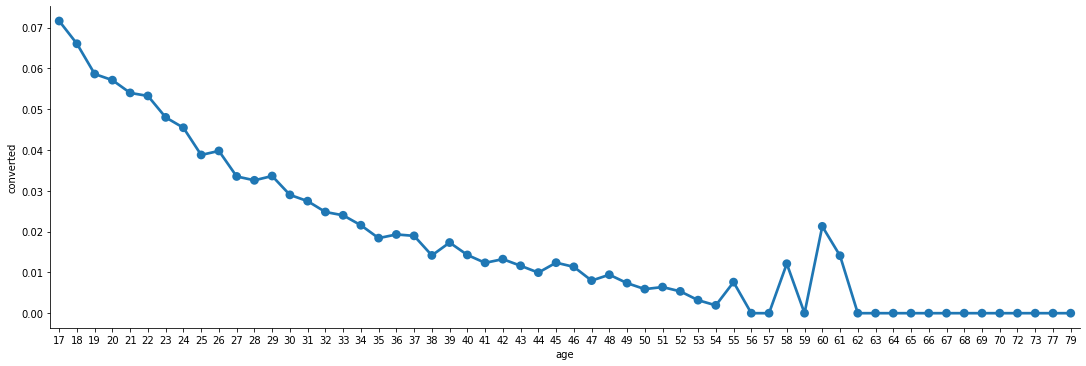

In [12]:
age = df.groupby('age')['converted'].mean().reset_index()
sns.catplot(x = 'age', y = 'converted', data = age, kind = 'point', aspect = 3)

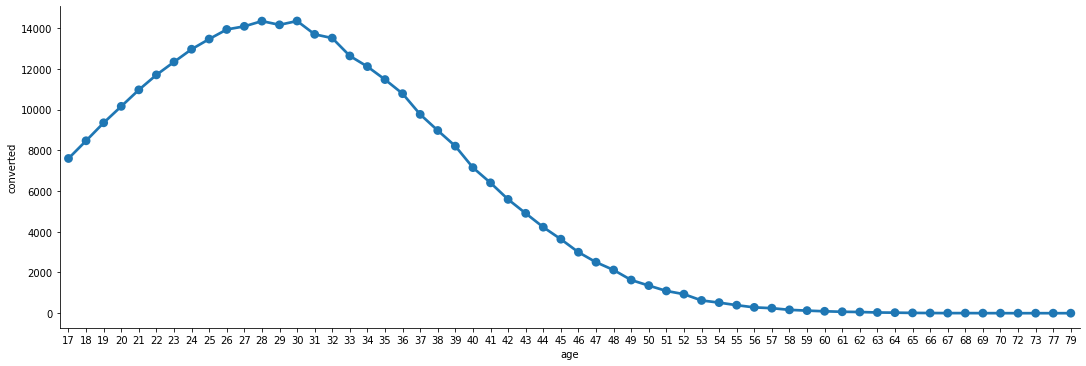

In [13]:
age_cnt = df.groupby('age')['converted'].count().reset_index()
sns.catplot(x = 'age', y = 'converted', data = age_cnt, kind = 'point', aspect = 3)

1. User base is pretty young
2. Younger users have higher conversion rate than elder ones.

6. Are there any correlations between number of page viewed and conversion rate?

In [14]:
page = df.groupby('total_pages_visited')['converted'].mean().reset_index()

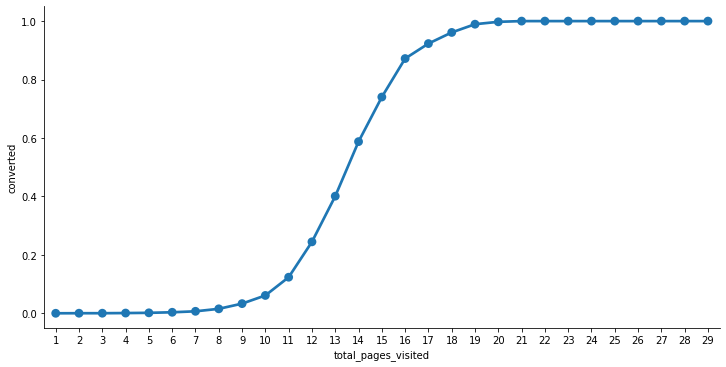

In [15]:
sns.catplot(x = 'total_pages_visited', y = 'converted', data = page, kind = 'point', aspect = 2)

In [16]:
page_cnt = df.groupby('total_pages_visited')['converted'].count().reset_index()

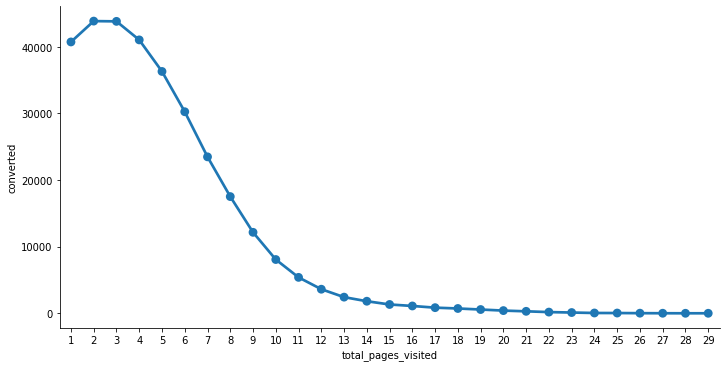

In [17]:
sns.catplot(x = 'total_pages_visited', y = 'converted', data = page_cnt, kind = 'point', aspect = 2)

1. More reviewed pages lead to larger conversion rate.

## 2. Machine Learning

I am going to pick a random forest to predict conversion rate. I picked a random forest because: it usually requires very little time to optimize it (its default params are often close to be the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. Also, I will build a simple tree to find the most obvious user segments. 

### 2.1 Build Model

In [18]:
df_dummy = pd.get_dummies(df, drop_first=True)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.random.seed(4684)

In [20]:
train, test = train_test_split(df_dummy, test_size = 0.34)

In [21]:
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, oob_score = True)

In [22]:
X_train = train.drop(columns = ['converted'])
y_train = train['converted']

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=3, oob_score=True)

In [24]:
print('oob score is ',
     rf.oob_score_,
     '\n',
     'oob confusion matrix is ',
      '\n',
     pd.DataFrame(confusion_matrix(y_train, rf.oob_decision_function_[:,1].round(), labels = [0, 1])))

oob score is  0.9838851885571901 
 oob confusion matrix is  
         0     1
0  200872  1102
1    2261  4455


In [25]:
X_test = test.drop(columns = ['converted'])
y_test = test['converted']

In [26]:
print('test accuracy is ',
     rf.score(X_test, y_test),
     '\n',
     'test confusion matrix is ',
     '\n',
     pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test), labels = [0, 1])))

test accuracy is  0.9847360196450496 
 test confusion matrix is  
         0     1
0  103483   543
1    1098  2384


### 2.2 Feature Importance

<AxesSubplot:>

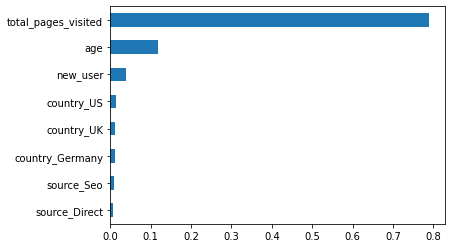

In [27]:
pd.Series(rf.feature_importances_, index = X_train.columns).sort_values().plot(kind = 'barh')

Total pages visited is the most important one, by far. Unfortunately, it is probably the least **“actionable”**. People visit many pages because they already want to buy.

### 2.3 Re-build Model

In [28]:
X_train_new = train.drop(columns = ['converted', 'total_pages_visited'])
X_test_new = test.drop(columns = ['converted', 'total_pages_visited'])

In [29]:
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, oob_score = True, class_weight = {0:1, 1:10})

In [30]:
rf.fit(X_train_new, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_features=3,
                       oob_score=True)

In [31]:
print('oob score is ',
     rf.oob_score_,
     '\n',
     'oob confusion matrix is ',
      '\n',
     pd.DataFrame(confusion_matrix(y_train, rf.oob_decision_function_[:,1].round(), labels = [0, 1])))

oob score is  0.889827016148354 
 oob confusion matrix is  
         0      1
0  182720  19254
1    3738   2978


In [32]:
print('test accuracy is ',
     rf.score(X_test_new, y_test),
     '\n',
     'test confusion matrix is ',
     '\n',
     pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test_new), labels = [0, 1])))

test accuracy is  0.8899802805372623 
 test confusion matrix is  
        0     1
0  94140  9886
1   1942  1540


### 2.4 New Feature Importance

<AxesSubplot:>

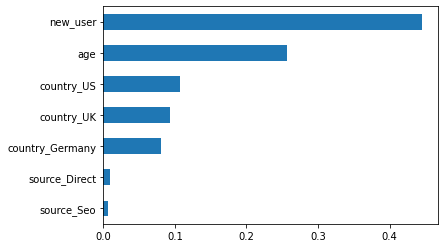

In [33]:
pd.Series(rf.feature_importances_, index = X_train_new.columns).sort_values().plot(kind = 'barh')

### 2.5 Partial Dependencies

In [34]:
from pdpbox import pdp, info_plots

<AxesSubplot:title={'center':'Country'}>

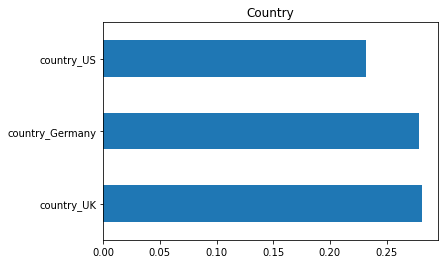

In [35]:
#country
pdp_iso = pdp.pdp_isolate(model = rf,
                         dataset = X_train_new,
                         model_features = list(X_train_new),
                         feature = ['country_Germany', 'country_UK', 'country_US'],
                         num_grid_points = 50)
pdp_dataset = pd.Series(pdp_iso.pdp, index = pdp_iso.display_columns)
pdp_dataset.sort_values(ascending = False).plot(kind = 'barh', title = 'Country')

In [36]:
pdp_iso.pdp

array([0.27817422, 0.28130706, 0.2321851 ])

<AxesSubplot:title={'center':'Source'}>

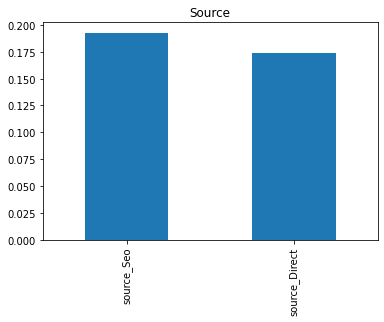

In [37]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

<AxesSubplot:title={'center':'New User'}>

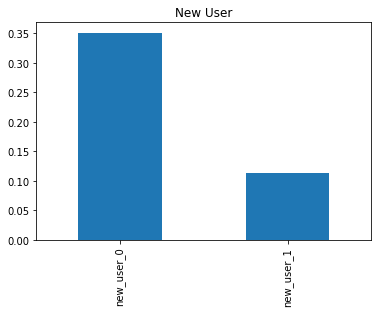

In [38]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

In [ ]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

### 2.6 Decision Tree

Decision Tree is one of the popular and most widely used Machine Learning Algorithms because of its robustness to noise, tolerance against missing information, handling of irrelevant, redundant predictive attribute values, low computational cost, interpretability, fast run time and robust predictors.    
[Decision Tree](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from IPython.display import Image
import pydotplus

In [ ]:
dt = DecisionTreeClassifier(max_depth = 2, class_weight = {0:1, 1:10}, min_impurity_decrease = 0.001)

In [ ]:
dt.fit(X_train_new, y_train)

In [ ]:
dt_feature_name = list(X_train_new)
dt_target_name = [str(s) for s in y_train.unique()]

tree.export_graphviz(dt,
                    out_file = 'tree1.dot',
                    feature_names = dt_feature_name,
                    class_names = dt_target_name,
                    filled = True)
graph = pydotplus.graph_from_dot_file('tree1.dot')
Image(graph.create_png())